# This tutorial illustrates the usage of wneq.

Begin by installing necessary packages.

In [1]:
import sys
!{sys.executable} -m pip install --quiet requests
!{sys.executable} -m pip install --quiet matplotlib
!{sys.executable} -m pip install --quiet numpy
!{sys.executable} -m pip install --quiet wnnet
!{sys.executable} -m pip install --quiet wneq

Next, import the necessary packages:

In [2]:
import os, io, requests
import matplotlib.pyplot as plt
import wnnet as wn
import numpy as np
import wneq as wq
from matplotlib import animation
from IPython.display import HTML

# Preliminaries

First, carry out some preliminary steps.  Define a routine to extract the maximum and minium mass numbers from a nuclide collection for an isotope chain.

In [3]:
def get_min_and_max_a(nuc, z):
    a_min = np.inf
    a_max = -np.inf
    for value in nuc.get_nuclides().values():
        if value['z'] == z:
            if value['a'] < a_min:
                a_min = value['a']
            if value['a'] > a_max:
                a_max = value['a']
    return (a_min, a_max)

Now define a routine to extract isotopic abundances from a zone.

In [4]:
def get_isotopic_abundances(zone, z):
    y = []
    a = []
    for key, value in zone['mass fractions'].items():
        if key[1] == z:
            a.append(key[2])
            y.append(value / key[2])

    y = [y for _, y in sorted(zip(a,y))]
    return (a, y)

Now define a routine to return elemental abundances from a zone.

In [5]:
def get_elemental_abundances(zone):
    z_max = 0
    for key in zone['mass fractions']:
        if key[1] > z_max:
            z_max = key[1]

    yz = np.zeros(z_max + 1)
    for key, value in zone['mass fractions'].items():
        yz[key[1]] += value / key[2]

    return yz

Here define a notebook to compute the abundances in a cluster of nuclei in a zone.

In [6]:
def compute_cluster_abundance(nuc, zone, xpath):
    cluster_nucs = nuc.get_nuclides(nuc_xpath = xpath)
    result = 0
    for key, value in zone['mass fractions'].items():
        if key[0] in cluster_nucs:
            result += value / key[2]

    return result

# $(n, \gamma)-(\gamma, n)$ Equilibrium

$(n, \gamma)-(\gamma, n)$ equilibrium occurs when isotopes are in equilibrium under exchange of neutrons.  The equilibrium condition is such that $\mu(Z, A) + \mu_n = \mu(Z, A+1)$, where $\mu(Z, A)$ is the chemical potential of the species with atomic number $Z$ and mass number $A$ and $\mu_n$ is the chemical potential of free neutrons.  The chemical potential of free neutrons is given by $\mu_n = m_nc^2 + \mu_n'$, where $m_nc^2$ is the rest mass energy of the neutron and $\mu_n'$ is the neutron chemical potential of the neutron less the rest mass.

To compute an $(n, \gamma)-(\gamma, n)$ equilibrium, first download the necessary nuclear data.   Here we create a nuclear data instance by reading the data from an example file from OSF. Alternatively, you can read a local file (called out_r.xml) as shown in the commented command.

In [7]:
nuc = wn.nuc.Nuc(io.BytesIO(requests.get('https://osf.io/xs53q/download').content))
#nuc = wn.nuc.Nuc('out_r.xml')

Now create an $(n, \gamma)-(\gamma, n)$ instance with the downloaded data.

In [8]:
my_ng = wq.ng.Ng(nuc)

## Equilibrium at fixed $\mu_n'$.

Compute an $(n, \gamma)-(\gamma, n)$ equilibrium for the $Z=50$ isotope chain at a particular temperature (in $10^9$ K), mass density $\rho$ in g/cc, and neutron chemical potential less rest mass.  Do this for the $Z = 50$ isotope chain such that the abundance of all tin isotopes in 0.01 per nucleon.  

In [9]:
Z = 50
t9 = 2
rho = 1.e5
yz = {Z: 0.01}

Now compute the equilibrium for the input $\mu_n'$ (in MeV).  The quantity $-\mu_n'$ is equal to the binding energy of neutrons inside of nuclei, averaged over their abundance in the network.  If $\mu_n'$ itself becomes more negative, the most abundant nuclei in the equilibrium will have a larger neutron separation energy and, consequently, a lower mass number.

The return from the routine to compute the equilibrium is a *zone*, which itself is a dictionary with *properties* and *mass fractions*.  The *properties* and *mass fractions* themselves are dictionaries.  The keys for the *properties* dictionary are either strings or tuples of strings and the values are the value of the property identified by the key.  The keys for the *mass fractions* are tuples, with each tuple giving the *name*, $Z$, and $A$ for the given species and the value being the mass fraction.  The cell below uses the zone properties to create the plot title.  The quantity $\mu_Z/kT$ is the chemical potential of the isotope chain as a whole divided by $kT$ ($k$ is Boltzmann's constant).  It indicates the isotopic abundance relative to the corresponding value that would be present in nuclear statistical equilibrium (NSE).  A large value indicates a large overabundance relative to NSE.  Try changing the isotopic abundance to see the effect on $\mu_Z/kT$.

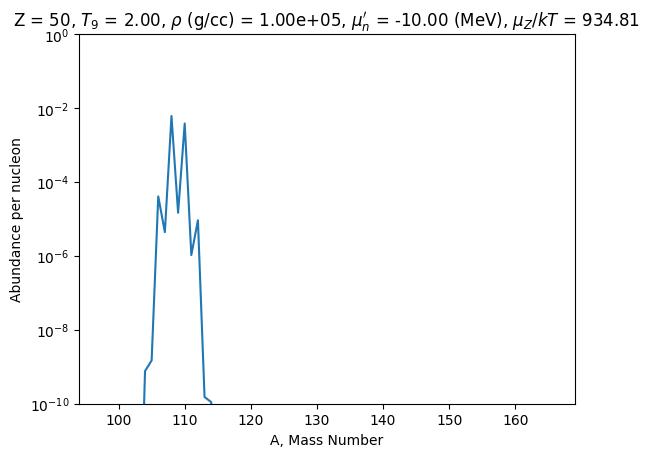

In [10]:
mun_prime = -10

ng_zone = my_ng.compute(t9, rho, mun_prime, yz)

a, y = get_isotopic_abundances(ng_zone, Z)

props = ng_zone['properties']

muz_kT = float(props[('muz_kt', str(Z))])

plt.title(f"Z = {Z}, $T_9$ = {props['t9']:.2f}, $\\rho$ (g/cc) = {props['rho']:.2e},\
 $\mu_n'$ = {mun_prime:.2f} (MeV), $\mu_Z/kT$ = {muz_kT:.2f}")

plt.plot(a, y)
plt.xlabel('A, Mass Number')
plt.ylabel('Abundance per nucleon')
plt.xlim([min(a), max(a)])
plt.ylim(1.e-10, 1)
plt.yscale('log')

## Equilibrium at a consistent neutron abundance.

The above calculation computed the $(n, \gamma)-(\gamma, n)$ equilibrium for a fixed neutron chemical potential.  In fact, an $(n, \gamma)-(\gamma)$ equilibrium should have mass fractions that sum to unity.  For a given set of isotopic abundances, this will only occur for a specific neutron abundance (and, thus, specific neutron chemical potential).  In this section, we perform such a consistent calculation.  Begin by choosing the temperature, density, and isotopic abundances for the calculation (in the default calculation, isotopes of $Z = 48$).

In [11]:
t9 = 2.5
rho = 1.e5
yz = {48: 0.009}

Now compute the equilibrium.

In [12]:
ng_zone_consistent = my_ng.compute_with_root(t9, rho, yz)

Now check that the mass fractions correctly sum to unity and print the neutron chemical potential.

In [13]:
x_sum = 0
for value in ng_zone_consistent['mass fractions'].values():
    x_sum += value

print(f"sum of mass fractions = {x_sum:.16f}")
print(f"mu_n_prime = {float(ng_zone_consistent['properties']['mun']):.2f} (MeV)")
print(f"mu_n_prime/kT = {float(ng_zone_consistent['properties']['mun_kt']):.2f}")

sum of mass fractions = 1.0000000000000020
mu_n_prime = -8.18 (MeV)
mu_n_prime/kT = -37.95


Now plot the abundances of the $Z = 48$ isotopic chain.  Include the neutron abundance and neutron number density in the plot title.

Text(0.5, 1.0, 'Z = 48, $Y_n$ = 2.61e-11, $n_n$ = 1.57e+18 (per cc)')

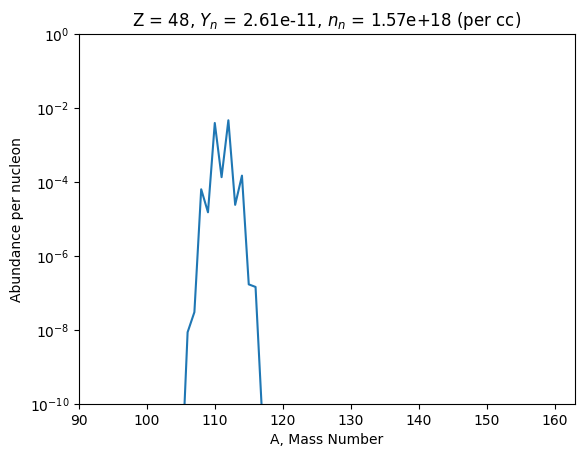

In [14]:
yn = ng_zone_consistent['mass fractions'][('n', 0, 1)]
nn = yn * wn.consts.N_A * float(ng_zone_consistent['properties']['rho'])
a, y = get_isotopic_abundances(ng_zone_consistent, 48)

plt.plot(a, y)
plt.xlabel('A, Mass Number')
plt.ylabel('Abundance per nucleon')
plt.xlim([min(a), max(a)])
plt.ylim(1.e-10, 1)
plt.yscale('log')

plt.title(f"Z = 48, $Y_n$ = {yn:.2e}, $n_n$ = {nn:.2e} (per cc)")

## Compare $(n, \gamma)-(\gamma, n)$ equilibrium to a network calculation.

Now one may compare the abundances for a isotope chain in a network calculation to $(n,\gamma)-(\gamma, n)$ equilibrium.  To do so, first retrieve the zone data for the network calculation.  The default example is for an r-process calculation.

In [15]:
zone_data = wn.zones.Zones(io.BytesIO(requests.get('https://osf.io/xs53q/download').content))
#zone_data = wn.zones.Zones('out_r.xml')

Now select a set of zones from the network calculation. For the default example, choose zones in the temperature range $3 \geq T_9 \geq 0.5$.

In [16]:
net_zones = zone_data.get_zones(zone_xpath="[optional_properties/property[@name = 't9'] < 3 and optional_properties/property[@name = 't9'] > 0.5]")
net_list = list(net_zones.values())

Now loop over these zones and compute the corresponding $(n, \gamma)-(\gamma, n)$ equilibrium.  Store the results in a new dictionary of zones. Update the initial guess for the equilibrium chemical potential for the next zone with that from the previous zone.  This can speed up the calculations.

In [17]:
ng_list = []
for i in range(len(net_list)):
    ng_zone = my_ng.compute_with_root_from_zone(net_list[i])
    my_ng.update_initial_guesses({'n': ng_zone['properties']['mun']})
    ng_list.append(ng_zone)

Create an animation of the evolution of the isotopic abundances of an element and compare to the corresponding equilibrium.

In [18]:
z = 50

a_min, a_max = get_min_and_max_a(nuc, z)

fig = plt.figure(figsize=(6,5))

def update_fig(i, net_list, ng_list):
    fig.clear()
    a_net, y_z_net = get_isotopic_abundances(net_list[i], z)
    a_ng, y_z_ng = get_isotopic_abundances(ng_list[i], z)

    plt.plot(a_net, y_z_net, label='Network')
    plt.plot(a_ng, y_z_ng, label='Equilibrium')

    time = float(net_list[i]['properties']['time'])
    t9 = float(net_list[i]['properties']['t9'])
    rho = float(net_list[i]['properties']['rho'])

    plt.title(f"time (s) = {time:.2e}, $T_9$ = {t9:.2f}, rho (g/cc) = {rho:.2e}")

    plt.xlabel('A, Mass Number')
    plt.ylabel('Abundance per nucleon')
    plt.yscale('log')
    plt.xlim([a_min, a_max])
    plt.ylim([1.e-10, 0.01])
    plt.legend()

    
anim = animation.FuncAnimation(fig, update_fig, frames=len(net_list), fargs=(net_list, ng_list,))
display(HTML(anim.to_jshtml()))
plt.close()

# General Nuclear Equilibria

General nuclear equilibrium is a free-energy minimum of the nuclear network.  The NSE (nuclear statistical equilibrium) condition is that the chemical potential of a species with atomic number $Z$ and mass number $A$ is $\mu(Z, A) = Z \mu_p + (A - Z) \mu_n$, where $\mu_p$ is the chemical potential of the free protons and $\mu_n$ is the chemical potential of the free neutrons.  If the electron fraction $Y_e$ is fixd, this is the commonly understood NSE since, in general, weak reactions that turn neutrons into protons, and vice versa, are slow.  If those reactions are not slow compared to other timescales in the problem, then the equilibrium is an NSE with weak equilibrium (a wNSE).  Alternatively, it may be that the $Y_e$ is fixed and also some non-weak nuclear reactions are slow, which leads to another abundance constraint.  This leads to a quasi-equilibrium (QSE).  In a QSE, the chemical potential of species $(Z, A)$ is given by $\mu(Z, A) = \tilde{\mu} + Z \mu_p + (A - Z) \mu_n$.  Here $\tilde{\mu}$ is a chemical potential offset.   Species in the same QSE cluster will have the same chemical potential offset.

To compute the relevant equilibria, first download the nuclear data.  Here, the default is to download and create a nuclear data instance relevant for an alpha-rich freezeout.  Alternatively, use another file (for example, *out.xml* in the commented example line).

In [19]:
nuc2 = wn.nuc.Nuc(io.BytesIO(requests.get('https://osf.io/m8erz/download').content))
#nuc2 = wn.nuc.Nuc('out.xml')

Now create an equilibrium instance to use in the subsequent calculations.

In [20]:
my_equil = wq.equil.Equil(nuc2)

## Compute equilibria at given conditions.

Here compute equilibria at a fixed set of conditions.  First, compute a common NSE by specifying the temperature, density, and electron fraction.

In [21]:
t9 = 6
rho = 1.e7
ye = 0.45

Now compute the NSE.

In [22]:
nse = my_equil.compute(t9, rho, ye = ye)

Print out the chemical potentials (less the rest mass) for the protons and neutrons in the NSE.

In [23]:
print(f"Proton chemical potential divided by kT: {nse['properties']['mup_kT']:.4f}")
print(f"Neutron chemical potential divided by kT: {nse['properties']['mun_kT']:.4f}")

Proton chemical potential divided by kT: -18.9424
Neutron chemical potential divided by kT: -16.1378


Now compute a quasi-equilibrium (QSE).  In the default calculation, define a QSE to be all nuclei with Z > 2 and set its fixed abundance per nucleon.

In [24]:
cluster = {"[z > 2]": 0.01}
qse = my_equil.compute(t9, rho, ye=ye, clusters = cluster)

Print out the chemical potentials for the QSE.

In [25]:
print(f"Proton chemical potential divided by kT: {qse['properties']['mup_kT']:.4f}")
print(f"Neutron chemical potential divided by kT: {qse['properties']['mun_kT']:.4f}")
print(f"Cluster chemical potential divided by kT: {qse['properties'][('cluster', '[z > 2]', 'mu_kT')]:.4f}")

Proton chemical potential divided by kT: -19.5658
Neutron chemical potential divided by kT: -14.8814
Cluster chemical potential divided by kT: -25.5172


Now plot the elemental abundances for the equilibria.  In the plot title, compare the cluster abundances.  In the default calculation, the number of heavy nuclei in the NSE exceeds that of the QSE, so the spontaneous evolution of the system would be that the QSE would tend to assemble light particles (neutrons, protons, and alpha particles) into more heavy nuclei.

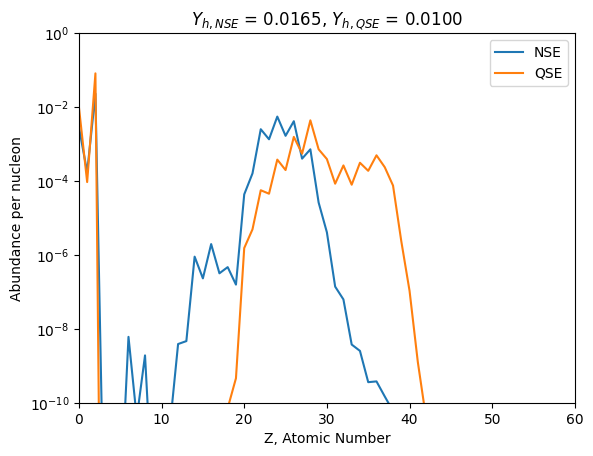

In [26]:
plt.plot(get_elemental_abundances(nse), label='NSE')
plt.plot(get_elemental_abundances(qse), label='QSE')

yh_nse = compute_cluster_abundance(nuc, nse, "[z > 2]")
yh_qse = compute_cluster_abundance(nuc, qse, "[z > 2]")

plt.title(f"$Y_{{h, NSE}}$ = {yh_nse:.4f}, $Y_{{h, QSE}}$ = {yh_qse:.4f}")

plt.xlabel('Z, Atomic Number')
plt.ylabel('Abundance per nucleon')
plt.yscale('log')
plt.xlim([0, 60])
plt.ylim([1.e-10, 1])
plt.legend()

## Compare a network calculation to the relevant equilibria.

One may compare the abundances in a network calculation to the corresponding equilibria the network would relax to, given sufficient time.  To do so, first download the zone data with the abundances from the network calculation.  For the default, use the abundances from the alpha-rich freezeout calculation.  The commented line shows how to use a different input file.

In [27]:
zone_data2 = wn.zones.Zones(io.BytesIO(requests.get('https://osf.io/m8erz/download').content))
#zone_data2 = wn.zones.Zones('out.xml')

Now select zones for the comparison.  For the default, choose timesteps (zones) with $T_9 > 1$.

In [28]:
net_zones = zone_data2.get_zones(zone_xpath="[optional_properties/property[@name = 't9'] >= 1]")
net_list = list(net_zones.values())

Now compute the NSE at the conditions for each network data zone.

In [29]:
nse_list = []
for i in range(len(net_list)):
    nse_zone = my_equil.compute_from_zone(net_list[i])
    my_equil.update_initial_guesses({'n': nse_zone['properties']['mun'], 'p': nse_zone['properties']['mup']})
    nse_list.append(nse_zone)

Now compute the QSE at the conditions for each network zone.  Since these calculations take some time to perform (roughly 20 minutes), the default is to skip them.  To include the QSE, change the value of *compute_qse* from *False* to *True*.

In [30]:
compute_qse = False

qse_list = []
if compute_qse:
    my_equil.update_initial_guesses({'n': -10, 'p': -10, '[z > 2]': -10})
    for i in range(len(net_list)):
        qse_zone = my_equil.compute_from_zone(net_list[i], clusters = ["[z > 2]"])
        my_equil.update_initial_guesses({'n': qse_zone['properties']['mun'], 'p': qse_zone['properties']['mup'],'[z > 2]': qse_zone['properties'][('cluster', '[z > 2]', 'mu_kT')]})
        qse_list.append(qse_zone)

Create an animation of the evolving abundances in the network, NSE, and, if selected, QSE.

In [31]:
fig = plt.figure(figsize=(6,5))

def update_fig2(i, net_list, nse_list, qse_list, compute_qse):
    fig.clear()
    plt.plot(get_elemental_abundances(net_list[i]), label='Network')
    plt.plot(get_elemental_abundances(nse_list[i]), label='NSE')
    if compute_qse:
        plt.plot(get_elemental_abundances(qse_list[i]), label='QSE')

    time = float(net_list[i]['properties']['time'])
    t9 = float(net_list[i]['properties']['t9'])
    rho = float(net_list[i]['properties']['rho'])

    plt.title(f"time (s) = {time:.2e}, $T_9$ = {t9:.2f}, rho (g/cc) = {rho:.2e}")

    plt.xlabel('Z, Atomic Number')
    plt.ylabel('Abundance per nucleon')
    plt.yscale('log')
    plt.xlim([0, 60])
    plt.ylim([1.e-10, 1])
    plt.legend()

    
anim = animation.FuncAnimation(fig, update_fig2, frames=len(net_list), fargs=(net_list, nse_list, qse_list, compute_qse))
display(HTML(anim.to_jshtml()))
plt.close()

## Compute a low-temperature NSE

Equilibrium abundances go as $\exp(B/kT)$, where $B$ is the species binding energy, $k$ is Boltzmann's constant, and $T$ is the temperature.  When $kT$ becomes much less than $B$, the exponentials involved in the nuclear abundances become very large, and equilibrium becomes difficult to compute by the normal root-finding methods.  On the other hand, since the normal nuclear statistical equilibrium becomes dominated by one or two species, one can simply compare the nuclear masses of pairs of nuclei to compute the equilibrium.  At extremely low temperature, the free energy is entirely governed by the rest mass of the species, so the equilibrium will be determined by the species or pair of species that minimizes the nuclear mass and, if relevant, satisfies the given electron fraction that minimizes the nuclear mass.  While low-temperature equilibria are not physically attainable, they are nevertheless interesting conceptually as goals of the network.  *wneq* allow one to compute such low-temperature equilibria.  To do so, first create an equilibrium instance.  In this case, use the nuclear data from a full network, but limit to $Z \leq 50$ since higher $Z$ nuclei will not be present in the low-temperature NSE.

In [32]:
nuc3 = wn.nuc.Nuc(io.BytesIO(requests.get('https://osf.io/grd4u/download').content), nuc_xpath = "[z <= 50]")
my_equil = wq.equil.Equil(nuc3)

Now print the mass fractions of the one or two species that would be present in the low-temperature NSE.

In [ ]:
for my_ye in np.linspace(0, 1, 51):
    low_t_zone = my_equil.compute_low_temperature_nse(ye = my_ye)
    print(f"For ye = {my_ye:.4f}:", end="")
    for key, value in low_t_zone['mass fractions'].items():
        print(f"   X({key[0]}) = {value:.4f}", end="")
    print()

For ye = 0.0000:   X(n) = 1.0000
For ye = 0.0200:   X(n) = 0.9344   X(kr118) = 0.0656
For ye = 0.0400:   X(n) = 0.8689   X(kr118) = 0.1311
For ye = 0.0600:   X(n) = 0.8033   X(kr118) = 0.1967
For ye = 0.0800:   X(n) = 0.7378   X(kr118) = 0.2622
For ye = 0.1000:   X(n) = 0.6722   X(kr118) = 0.3278
For ye = 0.1200:   X(n) = 0.6067   X(kr118) = 0.3933
For ye = 0.1400:   X(n) = 0.5411   X(kr118) = 0.4589
For ye = 0.1600:   X(n) = 0.4756   X(kr118) = 0.5244
For ye = 0.1800:   X(n) = 0.4100   X(kr118) = 0.5900
For ye = 0.2000:   X(n) = 0.3444   X(kr118) = 0.6556
For ye = 0.2200:   X(n) = 0.2789   X(kr118) = 0.7211
For ye = 0.2400:   X(n) = 0.2133   X(kr118) = 0.7867
For ye = 0.2600:   X(n) = 0.1478   X(kr118) = 0.8522
For ye = 0.2800:   X(n) = 0.0822   X(kr118) = 0.9178
For ye = 0.3000:   X(n) = 0.0167   X(kr118) = 0.9833
For ye = 0.3200:   X(fe76) = 0.1310   X(sr120) = 0.8690
For ye = 0.3400:   X(fe76) = 0.9172   X(sr120) = 0.0828
For ye = 0.3600:   X(ni78) = 0.9360   X(zn80) = 0.0640
For y